In [1]:
import tensorflow as tf
import numpy as np
from tensorflow.keras.layers import Conv2D, MaxPool2D  # Import Conv2D
from tensorflow.keras import models, layers, datasets, utils
import matplotlib.pyplot as plt
import pandas as pd
import qrcode
import os
import tensorflow as tf
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

In [2]:
# Function to generate QR code
def generate_qr_code(url, output_path):
    qr = qrcode.QRCode(version=1, error_correction=qrcode.constants.ERROR_CORRECT_L, box_size=10, border=4)
    qr.add_data(url)
    qr.make(fit=True)
    img = qr.make_image(fill_color="black", back_color="white")
    img.save(output_path)

In [3]:
# Function to create directories if they don't exist
def create_directories(good_dir, bad_dir):
    if not os.path.exists(good_dir):
        os.makedirs(good_dir)
    if not os.path.exists(bad_dir):
        os.makedirs(bad_dir)

In [4]:
# Read CSV file
csv_file = './phishing_site_urls.csv' # Change this to your CSV file name
df = pd.read_csv(csv_file)

# Output directories
good_dir = './QR_codes/good_qr_codes'
bad_dir = './QR_codes/bad_qr_codes'
create_directories(good_dir, bad_dir)

qr_codes_data = []
qr_code_counter = 0

In [5]:
for index, row in df.iterrows():
    url = row['URL']
    label = row['Label']  # Assuming column name is 'Label'
    output_path = os.path.join(good_dir if label == 'good' else bad_dir, f'{index}.png')
    generate_qr_code(url, output_path)
    qr_codes_data.append((url, label))
    qr_code_counter += 1
    if qr_code_counter >= 30000:
        print("Reached the limit of 30000 QR codes. Exiting the loop.")
        break

Reached the limit of 30000 QR codes. Exiting the loop.


In [6]:
# Splitting data into features and labels
urls, labels = zip(*qr_codes_data)

In [7]:
# Encoding labels
label_encoder = LabelEncoder()
labels = label_encoder.fit_transform(labels)

In [8]:
# Tokenizing URLs
tokenizer = Tokenizer()
tokenizer.fit_on_texts(urls)
sequences = tokenizer.texts_to_sequences(urls)
max_sequence_length = max([len(seq) for seq in sequences])
padded_sequences = pad_sequences(sequences, maxlen=max_sequence_length, padding='post')

In [9]:
X_train, X_test, y_train, y_test = train_test_split(padded_sequences, labels, test_size=0.2, random_state=42)

In [10]:
IMG_ROOT_DIR = "./QR_codes"
# Global params for loading the images
batch_size = 8
img_height = 76
img_width = 76

In [11]:
qr_train, qr_test = utils.image_dataset_from_directory(
    IMG_ROOT_DIR,
    validation_split=0.2,
    subset="both",
    seed=123,
    image_size=(img_height, img_width),
    batch_size=batch_size)


'''
print("Splitting training set into validation and training set...")
qr_train, qr_val = utils.split_dataset(
    qr_train, 
    left_size=0.8,
    shuffle = True,
    seed = 123)
'''
'''
qr_train = utils.image_dataset_from_directory(
    IMG_ROOT_DIR,
    validation_split=0.2,
    subset="training",
    seed=123,
    image_size=(img_height, img_width),
    batch_size=batch_size)
qr_val = utils.image_dataset_from_directory(
    IMG_ROOT_DIR,
    validation_split=0.2,
    subset="validation",
    seed=123,
    image_size=(img_height, img_width),
    batch_size=batch_size)
qr_test = utils.image_dataset_from_directory(
    IMG_ROOT_DIR,
    image_size=(img_height, img_width),
    batch_size=batch_size)
'''

Found 30000 files belonging to 2 classes.
Using 24000 files for training.
Using 6000 files for validation.


'\nqr_train = utils.image_dataset_from_directory(\n    IMG_ROOT_DIR,\n    validation_split=0.2,\n    subset="training",\n    seed=123,\n    image_size=(img_height, img_width),\n    batch_size=batch_size)\nqr_val = utils.image_dataset_from_directory(\n    IMG_ROOT_DIR,\n    validation_split=0.2,\n    subset="validation",\n    seed=123,\n    image_size=(img_height, img_width),\n    batch_size=batch_size)\nqr_test = utils.image_dataset_from_directory(\n    IMG_ROOT_DIR,\n    image_size=(img_height, img_width),\n    batch_size=batch_size)\n'

In [12]:
qr_train

<_PrefetchDataset element_spec=(TensorSpec(shape=(None, 76, 76, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int32, name=None))>

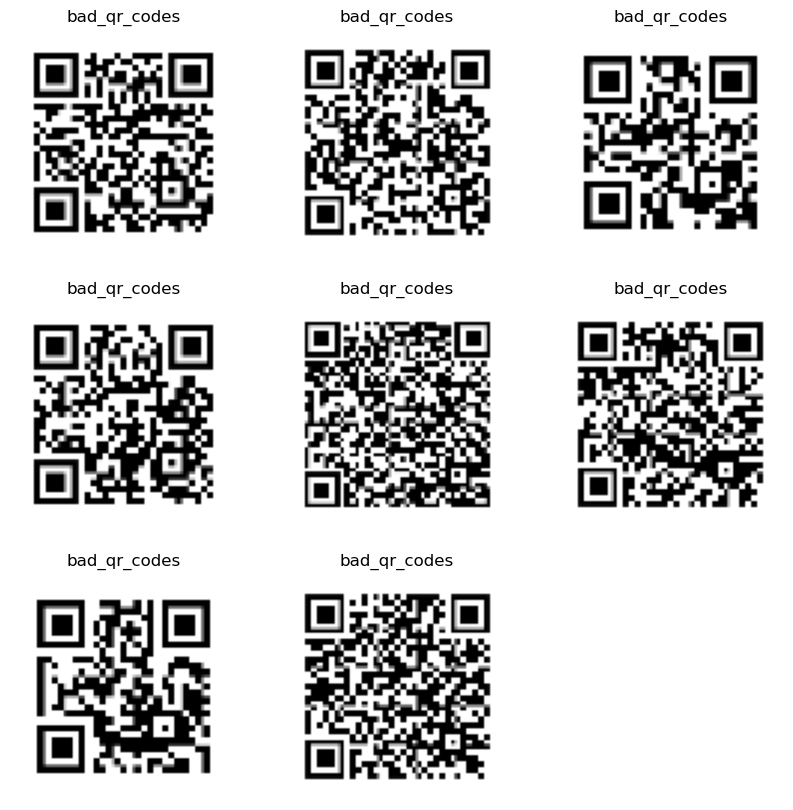

In [13]:
plt.figure(figsize=(10, 10))
for images, labels in qr_train.take(1):
  for i in range(8):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(qr_train.class_names[labels[i]])
    plt.axis("off")

In [14]:
# Show image sizes and other info (batch_size, height, width, color_channels)
for image_batch, labels_batch in qr_train:
  print(image_batch.shape)
  print(labels_batch.shape)
  break

(8, 76, 76, 3)
(8,)


In [15]:
# Normalization / Scaling of colors
normalization_layer = tf.keras.layers.Rescaling(1./255)
normalized_ds = qr_train.map(lambda x, y: (normalization_layer(x), y))
image_batch, labels_batch = next(iter(normalized_ds))
first_image = image_batch[0]
# Notice the pixel values are now in `[0,1]`.
print(np.min(first_image), np.max(first_image))
'''
# Do the same for the validation set
normalization_layer = tf.keras.layers.Rescaling(1./255)
normalized_ds = qr_val.map(lambda x, y: (normalization_layer(x), y))
image_batch, labels_batch = next(iter(normalized_ds))

# Do the same for the testing set
normalization_layer = tf.keras.layers.Rescaling(1./255)
normalized_ds = qr_test.map(lambda x, y: (normalization_layer(x), y))
image_batch, labels_batch = next(iter(normalized_ds))
'''

0.0 1.0


'\n# Do the same for the validation set\nnormalization_layer = tf.keras.layers.Rescaling(1./255)\nnormalized_ds = qr_val.map(lambda x, y: (normalization_layer(x), y))\nimage_batch, labels_batch = next(iter(normalized_ds))\n\n# Do the same for the testing set\nnormalization_layer = tf.keras.layers.Rescaling(1./255)\nnormalized_ds = qr_test.map(lambda x, y: (normalization_layer(x), y))\nimage_batch, labels_batch = next(iter(normalized_ds))\n'

In [16]:
# Cache datasets for performance
AUTOTUNE = tf.data.AUTOTUNE

qr_train = qr_train.cache().prefetch(buffer_size=AUTOTUNE)
# qr_val = qr_val.cache().prefetch(buffer_size=AUTOTUNE)
qr_test = qr_test.cache().prefetch(buffer_size=AUTOTUNE)

In [17]:
# Create a model
num_classes = 2

model = tf.keras.Sequential([
  #tf.keras.layers.Rescaling(1./255),
  tf.keras.layers.Conv2D(32, 3, activation='relu', input_shape=(img_width, img_height, 3)),
  tf.keras.layers.MaxPooling2D(),
  tf.keras.layers.Conv2D(32, 3, activation='relu'),
  tf.keras.layers.MaxPooling2D(),
  tf.keras.layers.Conv2D(32, 3, activation='relu'),
  tf.keras.layers.MaxPooling2D(),
  tf.keras.layers.Flatten(),
  tf.keras.layers.Dense(128, activation='relu'),
  tf.keras.layers.Dense(num_classes)
])

# Compile (Adam)
model.compile(
  optimizer='adam',
  loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
  metrics=['accuracy'])

model.summary()

C:\Users\curse\anaconda3\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:99: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                      │ (None, 74, 74, 32)          │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 37, 37, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 35, 35, 32)          │           9,248 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 17, 17, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 15, 15, 32)          │           9,248 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (None, 7, 7, 32)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 1568)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 128)                 │         200,832 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 2)                   │             258 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 220,482 (861.26 KB)

 Trainable params: 220,482 (861.26 KB)

 Non-trainable params: 0 (0.00 B)

In [18]:
model.fit(
  qr_train,
  #validation_split=0.2,
  epochs=3
)

Epoch 1/3
3000/3000 ━━━━━━━━━━━━━━━━━━━━ 109s 35ms/step - accuracy: 0.9933 - loss: 0.4836
Epoch 2/3
3000/3000 ━━━━━━━━━━━━━━━━━━━━ 64s 21ms/step - accuracy: 0.9979 - loss: 0.0213
Epoch 3/3
3000/3000 ━━━━━━━━━━━━━━━━━━━━ 65s 22ms/step - accuracy: 0.9973 - loss: 0.0406


In [19]:
evaluation = model.evaluate(qr_test)
print("Accuracy of testing: {}".format(evaluation[1]))

750/750 ━━━━━━━━━━━━━━━━━━━━ 18s 23ms/step - accuracy: 0.9957 - loss: 0.0328
Accuracy of testing: 0.9961666464805603


In [20]:
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

In [21]:
import cv2
import numpy as np
import pytesseract

In [55]:
tokenizer = Tokenizer()
tokenizer.fit_on_texts(urls)
sequences = tokenizer.texts_to_sequences(urls)
max_sequence_length = max([len(seq) for seq in sequences])
padded_sequences = pad_sequences(sequences, maxlen=max_sequence_length, padding='post')
max_sequence_length = 100

In [59]:
def predict_qr_code(image_path, tokenizer, model, max_sequence_length):  
    # Read and preprocess the input image
    image = cv2.imread(image_path)
    resized_image = cv2.resize(image, (76, 76))
    resized_image = resized_image / 255.0  # Normalize pixel values to [0, 1]

    prediction = model.predict(np.expand_dims(resized_image, axis=0))
    predicted_label = "good" if prediction[0][0] > 0.5 else "bad"  # Compare each element of prediction separately
    return predicted_label

In [61]:
# Specify the path to the Tesseract executable
pytesseract.pytesseract.tesseract_cmd = r'.\Tesseract-OCR\tesseract.exe'  # Example path, adjust it based on your installation

max_sequence_length = 100

image_path = "./download1.png"  
predicted_label = predict_qr_code(image_path, tokenizer, model, max_sequence_length) 
print("Predicted label:", predicted_label)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
Predicted label: bad
